# MDI 230 - PROJET EPIDEMIOLOGIE

# Jean Sainte-Beuve - Haoua Ben Ali Abbo

In [3]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import random

## Modélisation déterministe

In [2]:
def SIR_deterministe(beta, gamma, T, N):

    # définition de la dérivée de y
    def d_SIR(y, t):
        S, I, R = y
        dS = - beta * I * S
        dI = beta * I *S - gamma * I
        dR = gamma * I
        return [dS, dI, dR]

    temps = np.linspace(0, T, N)
    y0 = [0.99, 0.01, 0] # conditions initiales
    y = odeint(d_SIR, y0, temps) 

    return temps, y

# plot y en fonction de temps
def visualisation(temps, y):
    
    plt.figure(figsize=(10, 6))
    plt.plot(temps, y)
    plt.legend(['s(t)', 'i(t)', 'r(t)'])
    plt.xlabel('temps')
    plt.ylabel('pourcentage de la population')
    plt.title("Modèle SIR")
    plt.show()

    



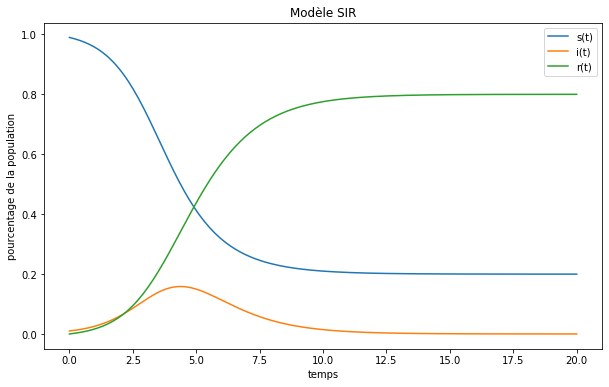

In [3]:
# résolution et affichage du système déterministe SIR, avec beta=2, gamma=1
temps, y = SIR_deterministe(beta=2, gamma=1, T=20, N=200)
visualisation(temps, y)

## Modélisation Markovienne

On défini l'espace d'état de notre processus de Markov comme : $E = \{(S, I, R) : S + I + R = N\}$ avec $N$ la population totale

Pour déterminer la trajectoire de notre modèle, nous allons réutiliser le même raisonnement que pour les trottinettes. Ainsi la théorie ne sera pas redétaillée :((

In [4]:
# données
N = 1000 # population totale
T = 1000 # durée de la trajectoire
beta = 2
gamma = 1



In [5]:
# simule l'évolution du processus de Markov pour une population de N individu avec les paramètre beta et gamma, sur une durée T
def markov_SIR(beta, gamma, T, N):

    # conditions initiales
    E = [N-1, 1, 0]
    t = 0 # temps auquel est le processus
    y = [E[:]] # processus de Markov
    temps = [0] # interval de temps considéré

    while (t < T): 
        # calcul des taux de transition
        q = np.zeros(2)
        q[0] = beta * E[1] * E[0] / N
        q[1] = gamma * E[1]

        if (sum(q)==0):#si il n'y a plus que des sains ou retirés
            break

        # recherche du temps t1 au bout duquel le processus va passer dans un nouvel état)
        t1 = random.expovariate(sum(q))

        ### mise à jour du processus
        # calcul des probabilités de transition
        P = q / sum(q) # probabilités de transition
        
        # tirage d'une va suivant une loi uniforme sur [0, 1]
        U = np.random.uniform(0, 1)
        # définition de la transition effectuée
        if (E[0]>0) and (E[1]>0):
            if (U < P[0]): # un susceptible devient inffecté
                E[0] -= 1
                E[1] += 1
            else:# un infecté est retiré
                E[1] -= 1
                E[2] += 1
        elif (E[0]>0) and not (E[1]>0):# un susceptible devient inffecté
            E[0] -= 1
            E[1] += 1
        elif not (E[0]>0) and (E[1]>0):# un infecté est retiré
            E[1] -= 1
            E[2] += 1
        elif (E[0]==0) and (E[1]==0): 
            break



        # mise à jour de la trajectoire du processus de Markov
        y.append(E[:])
        t += t1 #mise à jour du temps
        temps.append(t)

    return temps, y

   


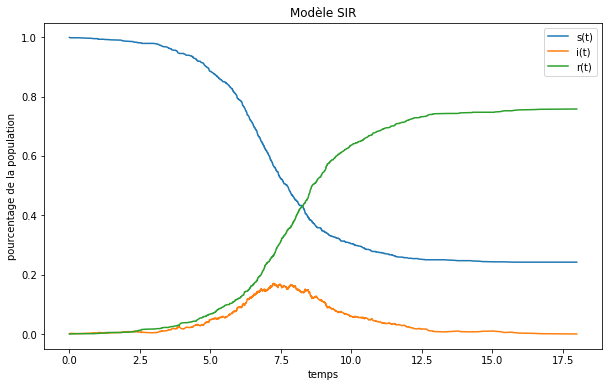

In [6]:
#avec les donées:
N = 1000 # population totale
T = 1000 # durée de la trajectoire
beta = 2
gamma = 1
temps, y = markov_SIR(beta=beta, gamma=gamma, T=T, N=N)

# Visualisation
y = np.array(y)
y = y / N # on veut visualiser les pourcentages
visualisation(temps, y)


On remarque que pour $\beta = 2, \gamma=1$ sur le long terme, tout le monde n'est pas retiré, une partie de la population est retirée et l'autre reste susceptible. On retrouve bien les résulats du modèle SIR déterministe pour les mêmes paramètres.

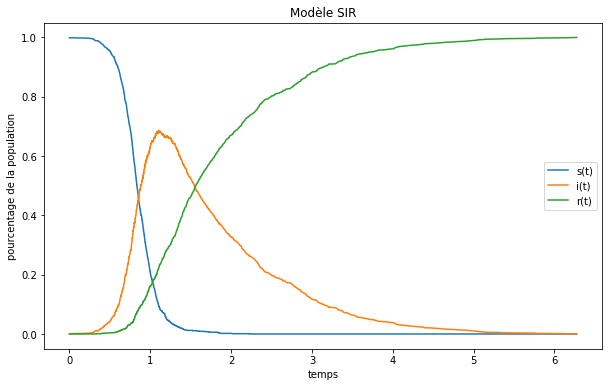

In [8]:
#avec les donées:
N = 1000 # population totale
T = 1000 # durée de la trajectoire
beta = 10
gamma = 1
temps, y = markov_SIR(beta=beta, gamma=gamma, T=T, N=N)

# Visualisation
y = np.array(y)
y = y / N # on veut visualiser les pourcentages
visualisation(temps, y)

Pour $\beta = 10, \gamma=1$ sur le long terme, tout le monde est retiré.

## Convergence du processus de Markov

J'ai choisi d'étudier l'évolution de la MSE en fonction de la population totale N, pour chacune des courbes

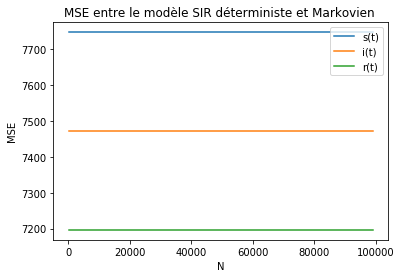

In [9]:
#avec les donées:
N = 100000 # nbre max de population totale
n_range = [] # liste contenant les le nombre de popu totale pris à chaque mesure de l'erreur
T = 20 # durée de la trajectoire
beta = 10
gamma = 1
e = [] # liste contenant les MSE des courbes pour tout n
E = np.zeros(3) # liste contenant la MSE des courbes à n

for n in range(100, N, 1000):
    temps_m, y_m = markov_SIR(beta=beta, gamma=gamma, T=T, N=200)
    temps_d, y_d = SIR_deterministe(beta=beta, gamma=gamma, T=T, N=n)
    y_m, y_d = np.array(y_m), np.array(y_d) # pour pouvoir faire des opérations dessus

    # pour résoudre nos problèmes de taille engendré par nos breaks plus haut
    taille = min(len(temps_m), len(temps_d))
    y_m, y_d = y_m[:taille], y_d[:taille]

    # Pour chaque courbe on calcule la MSE
    for j in range(3):
        E[j] = 1 / taille * np.sum((y_m.T[j] - y_d.T[j])**2)
    e.append(E[:])
    n_range.append(n)

#e = np.array(e)
#plt.plot(n_range, e.T[0])
plt.plot(n_range, e)
plt.legend(['s(t)', 'i(t)', 'r(t)'])
plt.title("MSE entre le modèle SIR déterministe et Markovien ")
plt.xlabel('N')
plt.ylabel('MSE')
plt.show()

## Question ouverte

A partir des données de Santé Publique France,, notamment le fichier "donnees_hospitalieres_nouveaux_covid19..." qui comportent 4 colonnes : les hospitalisations (hos), les admissions en réanimation (rea), les décès (dc) et les retournés à la maison (rad) pour chaque jour et pour chaque département, comment feriez-vous pour estimer gamma et beta, les paramètres du modèle SIR, sur un département donné ?

**Réponse:**

*méthode n°1*: Si on avait suffisemment de données, ce qui est malheuresement le problème majeur lors d'une pandémie, j'utiliserai un réseau de neuronne associé à la fonction de perte MSE. J'essaierai alors d'entrainer mon réseau avec des données des mois précédents, ou des régions différentes même si cela peut biaiser mon estimation (il faudrait rester dans des régions avec des conditions sanitaires assez proches), pour lesquels on connait les $\beta$ et $\gamma$, j'ajusterai mon modèle avec une cross-validation ou differentes méthodes pour éviter l'overfitting. 

*méthode n°2*: En MACS, nous avons rapidement vu la méthode de Monte Carlo par chaînes de Markov (MCMC) et je crois deviner qu'elle nous serait très utile dans notre situation. En effet, elle pourrait nous permettre d'estimer la distribution de probabilité des paramètres. On pourrait utiliser alors l'algorithme de Metropolis-Hasting, que nous devons d'ailleurs coder pour la semaine prochaine en MACS :)).

*méthode n°3*: On commence par extraire les données relatives à chaque département en particulier.
Pour estimer les paramètres $\beta$ et $\gamma$ , on s’appuie d’abord sur une fonction loss qui calcule la MSE entre les compartiments SIR prédits et réels. 
Ensuite, les valeurs initiales des paramètres $\beta$ et $\gamma$  sont définies en utilisant les moyennes des infectés (i) et des décès (r) divisées par la taille de la population (N). Les bornes sont définies pour s'assurer que les paramètres restent dans des limites raisonnables (entre 0 et 1).
Enfin on optimize les paramètre grâce à a fonction minimize de la bibliothèque scipy.optimize permettant de trouver les valeurs des paramètres $\beta$ et $\gamma$  qui minimisent la fonction de perte loss.
Une fois l'optimisation terminée, la fonction retourne les valeurs des paramètres β et γ qui ont été estimées comme minimisant la fonction de perte et c’est ainsi qu’on obtient les paramètres du modèle.



In [9]:
"""Implémentation de la méthode 3"""

import pandas as pd
from scipy.optimize import minimize

# Chargement des données depuis le fichier CSV
data = pd.read_csv("/Users/haouabenaliabbo/Downloads/donnees-covid.csv", sep=";")

# extraction des données pour chaque département
def extract_data(data, dep):
    data_dep = data[data["dep"]==f"{dep}"]
    jours = data_dep["jour"].values
    hos = data_dep["incid_hosp"].values
    rea = data_dep["incid_rea"].values
    dc = data_dep["incid_dc"].values
    rad = data_dep["incid_rad"].values
    return jours, hos, rea, dc, rad

# modèle sir à partir des données extraites 

def sir_model(params,N, dep):
    jours, hos, rea, dc, rad = extract_data(data, dep)
    n=len(jours)
    s = np.zeros(n)
    i = np.zeros(n)
    r = np.zeros(n)
    for t in range(n):
        i[t]=hos[t]+rea[t]
        r[t]=dc[t]+rad[t]
        s[t]=N-i[t]-r[t]
    return s, i, r

def estimate_parameters(sir_model_func, s, i, r, N, dep):
    def loss(params):
        s_pred, i_pred, r_pred = sir_model_func(params, N, dep)
        return np.linalg.norm(s_pred-s) + np.linalg.norm(i_pred-i) + np.linalg.norm(r_pred-r)

    # Valeurs initiales basées sur les données
    initial_guess = [np.mean(i) / N, np.mean(r) / N]  # Moyenne de i/N et r/N
    bounds = [(0, 1), (0, 1)]  # Bornes pour beta et gamma
    result = minimize(loss, initial_guess, bounds=bounds)
    return result.x

"""Exemple pour le département 75"""

N = 2145906 # population du departement 75 en 2020
dep = 75
s,i,r=sir_model(1, N, dep)
beta, gamma = estimate_parameters(sir_model, s, i, r, N, dep)
print("beta estimé pour le département 75:", beta)
print("gamma estimé pour le département 75:", gamma)
print("R0 du département 75:", beta/gamma)


beta estimé pour le département 75: 3.221250138636082e-05
gamma estimé pour le département 75: 2.3496115181864697e-05
R0 du département 75: 1.3709713770565697


On utilise l'ouvrage de recherche "COVID-19 : Détermination des paramètres R°, β et γ d’un modèle SIR de l’épidémie à partir des décès à l’hôpital en France sur la période du 19 février au 1er juillet 2020" de Christian Manivel. Les valeurs obtenues theoriques sur toute la France dans cette période sont R0=5.5 et beta = 1.53e-6.

Pour le département 75, l'ordre de grandeur est proche, et le R0 est plus faible par rapport à la moyenne nationale.Toutefois, on remarque qu'il reste supérieur à 1.